In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rc('figure', figsize=(10,5))
sns.set_theme(style='darkgrid')
sns.set_palette('plasma')

In [3]:
df_transaction_history = pd.read_excel("../raw_data/Customer_Churn_Data_Large.xlsx", sheet_name='Transaction_History')
df_transaction_history.head()

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


In [4]:
df_transaction_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       5054 non-null   int64         
 1   TransactionID    5054 non-null   int64         
 2   TransactionDate  5054 non-null   datetime64[ns]
 3   AmountSpent      5054 non-null   float64       
 4   ProductCategory  5054 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 197.6+ KB


The dataset is clean without any null values.  
There are multiple transaction histories for a given customer, so feature engineering is required to aggregate multiple histories and create relevant features.

In [5]:
df_transaction_history.duplicated().sum()
# checking for duplicates
# there are no duplicates in the dataset

np.int64(0)

In [6]:
df_transaction_history[['AmountSpent', 'ProductCategory']].describe(include='all').T
# the features for which summary statistics are relevant are AmountSpent and ProductCategory
# descriptive statistics of the dataset

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AmountSpent,5054.0,NaN,NaN,NaN,250.707351,142.250838,5.18,127.105,250.525,373.4125,499.86
ProductCategory,5054,5,Books,1041,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The amount spent ranges from 5 to 499 and is uniformly distributed.
The Product category is also uniformly distributed.

TransactionID is a redundant column. It represents an id to refer to the transaction which is irrelevant to customer churn, so it can be dropped. 

In [7]:
df_transaction_history.drop(columns=['TransactionID'], inplace=True)
# dropping TransactionID column as it is not relevant for analysis

In [8]:
df_transaction_history.head()

,CustomerID,TransactionDate,AmountSpent,ProductCategory
0,1,2022-03-27,416.50,Electronics
1,2,2022-08-08,54.96,Clothing
2,2,2022-07-25,197.50,Electronics
3,2,2022-01-25,101.31,Furniture
4,2,2022-07-24,397.37,Clothing


<Axes: xlabel='TransactionDate', ylabel='Count'>

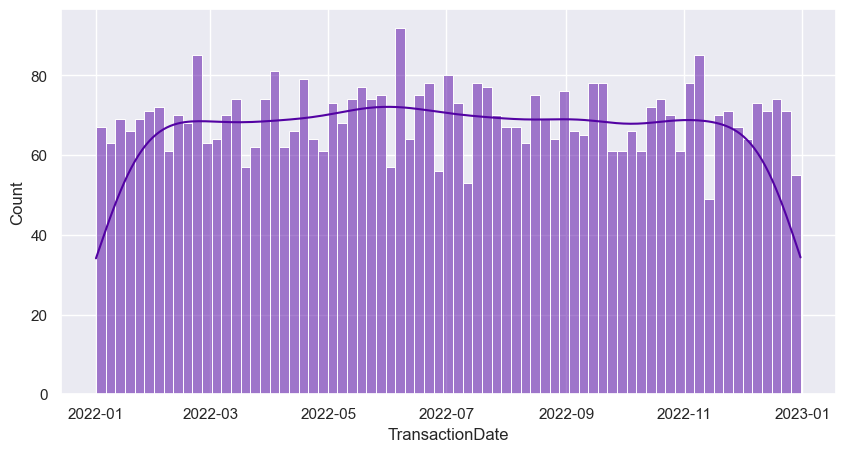

In [9]:
# plotting the TransactionDate column
sns.histplot(df_transaction_history['TransactionDate'], binwidth=5, kde=True)

<Axes: xlabel='AmountSpent', ylabel='Count'>

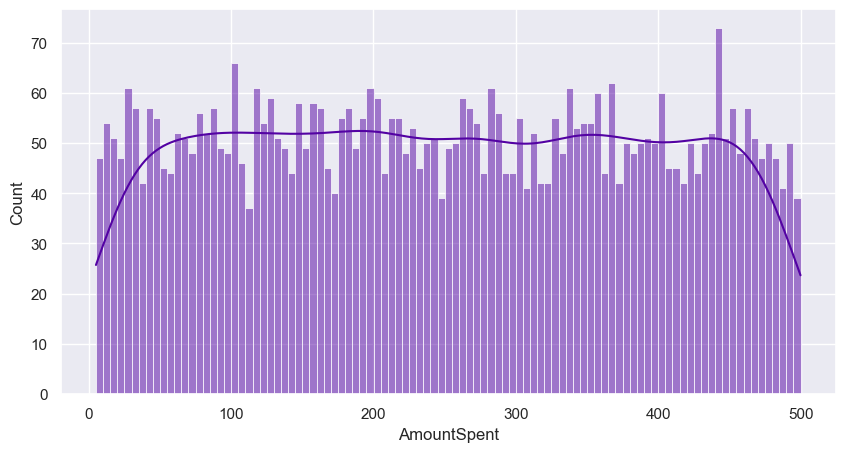

In [10]:
# plotting AmountSpent column
sns.histplot(df_transaction_history['AmountSpent'], binwidth=5, kde=True)

The Customer transactions and Amount spent are roughly uniformly distributed. 

<Axes: xlabel='ProductCategory', ylabel='count'>

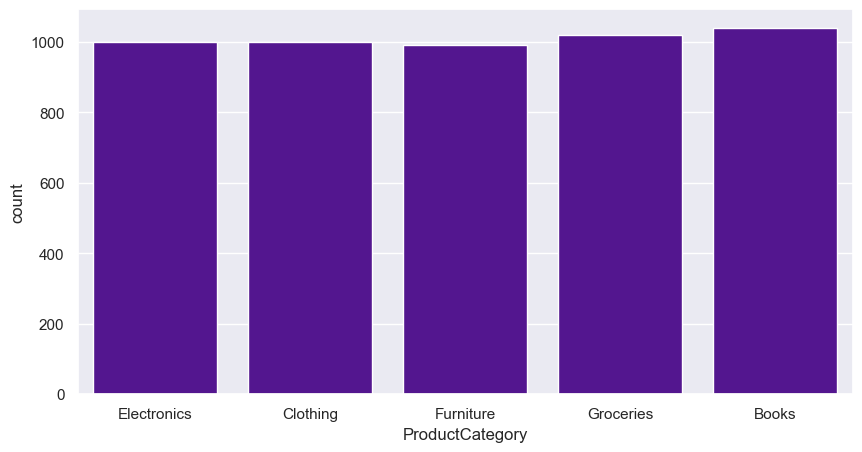

In [11]:
# plotting ProductCategory column
sns.countplot(df_transaction_history, x='ProductCategory')
# this plot shows the number of transactions in each product category

<Axes: xlabel='ProductCategory', ylabel='AmountSpent'>

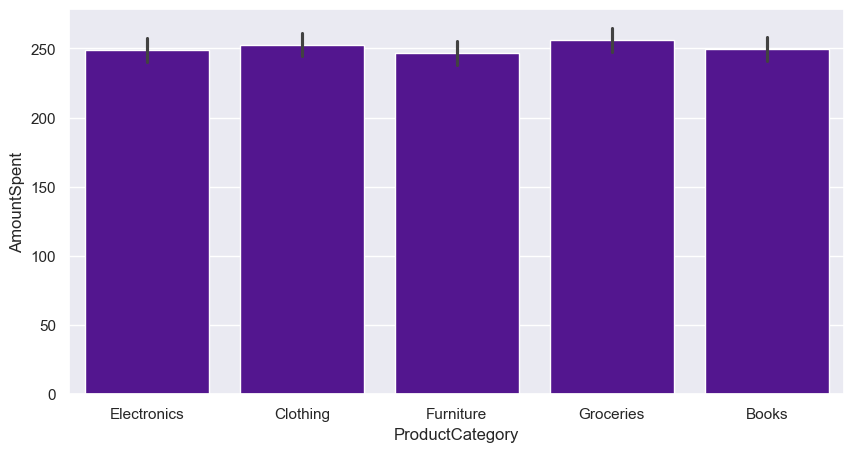

In [12]:
# mean amount spent in each product category
sns.barplot(df_transaction_history, x='ProductCategory', y='AmountSpent', estimator='mean')
# this plot shows the mean amount spent in each product category

In [13]:
df_transaction_history_agg = df_transaction_history.groupby('CustomerID', as_index=False).agg(
    {'AmountSpent': 'sum'}).rename(
    columns={'AmountSpent': 'TotalAmountSpent'})
# this shows the total amount spent for each customer

df_transaction_history_agg

,CustomerID,TotalAmountSpent
0,1,416.50
1,2,1547.42
2,3,1702.98
3,4,917.29
4,5,2001.49
...,...,...
995,996,227.25
996,997,419.82
997,998,252.15
998,999,2393.26


In [14]:
# finding number of days from earliest transaction date and latest transaction date to the most recent transaction date
df_transaction_history['Days_since_transaction'] = (df_transaction_history['TransactionDate'].max()-df_transaction_history['TransactionDate']).dt.days
df_transaction_history

,CustomerID,TransactionDate,AmountSpent,ProductCategory,Days_since_transaction
0,1,2022-03-27,416.50,Electronics,279
1,2,2022-08-08,54.96,Clothing,145
2,2,2022-07-25,197.50,Electronics,159
3,2,2022-01-25,101.31,Furniture,340
4,2,2022-07-24,397.37,Clothing,160
...,...,...,...,...,...
5049,1000,2022-09-08,232.06,Groceries,114
5050,1000,2022-12-13,324.98,Books,18
5051,1000,2022-06-15,375.34,Groceries,199
5052,1000,2022-04-08,166.73,Books,267


In [15]:
# adding columns days since first transaction and days since last transaction to the aggregated dataframe
df_days = df_transaction_history.groupby('CustomerID', as_index=False)['Days_since_transaction'].agg(['min', 'max'])
df_days.rename(columns={'max': 'Days_since_first_transaction', 'min': 'Days_since_last_transaction'}, inplace=True)

df_transaction_history_agg = df_transaction_history_agg.merge(df_days, on='CustomerID', how='left')
# merging the aggregated dataframe with the days dataframe on CustomerID

df_transaction_history_agg

,CustomerID,TotalAmountSpent,Days_since_last_transaction,Days_since_first_transaction
0,1,416.50,279,279
1,2,1547.42,42,356
2,3,1702.98,84,323
3,4,917.29,4,223
4,5,2001.49,10,313
...,...,...,...,...
995,996,227.25,160,160
996,997,419.82,67,147
997,998,252.15,104,104
998,999,2393.26,24,345


In [16]:
# creating the counts of each product category for each customer
product_category_df = df_transaction_history.groupby(['CustomerID', 'ProductCategory']).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
product_category_df.head()

,CustomerID,Books,Clothing,Electronics,Furniture,Groceries
0,1,0,0,1,0,0
1,2,0,2,3,1,1
2,3,1,1,0,2,2
3,4,0,1,2,1,1
4,5,0,0,3,2,3


In [17]:
# merging the product category dataframe with the aggregated dataframe on CustomerID
df_transaction_history_agg = df_transaction_history_agg.merge(product_category_df, on='CustomerID', how='left')
df_transaction_history_agg.head()

,CustomerID,TotalAmountSpent,Days_since_last_transaction,Days_since_first_transaction,Books,Clothing,Electronics,Furniture,Groceries
0,1,416.50,279,279,0,0,1,0,0
1,2,1547.42,42,356,0,2,3,1,1
2,3,1702.98,84,323,1,1,0,2,2
3,4,917.29,4,223,0,1,2,1,1
4,5,2001.49,10,313,0,0,3,2,3


The categorical features has been converted to numeric values.

In [18]:
df_transaction_history_agg.to_csv("../processed_data/Transaction_History.csv", index=False)